In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import py
import pandas as pd
import seaborn as sns
from collections import OrderedDict
import glob
import os
import re
from IPython.display import FileLink
import pyprind
from khmer import Countgraph
#from khmer._oxli.partitioning import StreamingPartitioner
#from khmer._oxli.app import PartitioningApp
from khmer import LinearAssembler
import json

Populating the interactive namespace from numpy and matplotlib


In [4]:
sns.set_style('ticks')

In [134]:
def get_readnum(path):
    reg = re.compile(r'.*-(?P<num>[0-9]*)\.stats\.csv$')
    return int(reg.search(path).groupdict()['num'])

def parse_stats_files(stats_dir, read_num_func=get_readnum):
    
    stats_files = [os.path.abspath(p) for p in glob.glob(os.path.join(stats_dir,'*.csv'))]
    stats_files.sort(key=read_num_func)
    
    bar = pyprind.ProgBar(len(stats_files), monitor=True)
    
    data = OrderedDict()
    for filename in stats_files:
        df = pd.read_csv(filename, header=None, names=['comp_id', 'n_tags', 'mean_cov'])
        data[read_num_func(filename)] = df
        bar.update()
    return data

In [6]:
full_data = parse_stats_files('../../khmer/test-stats/')

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:38


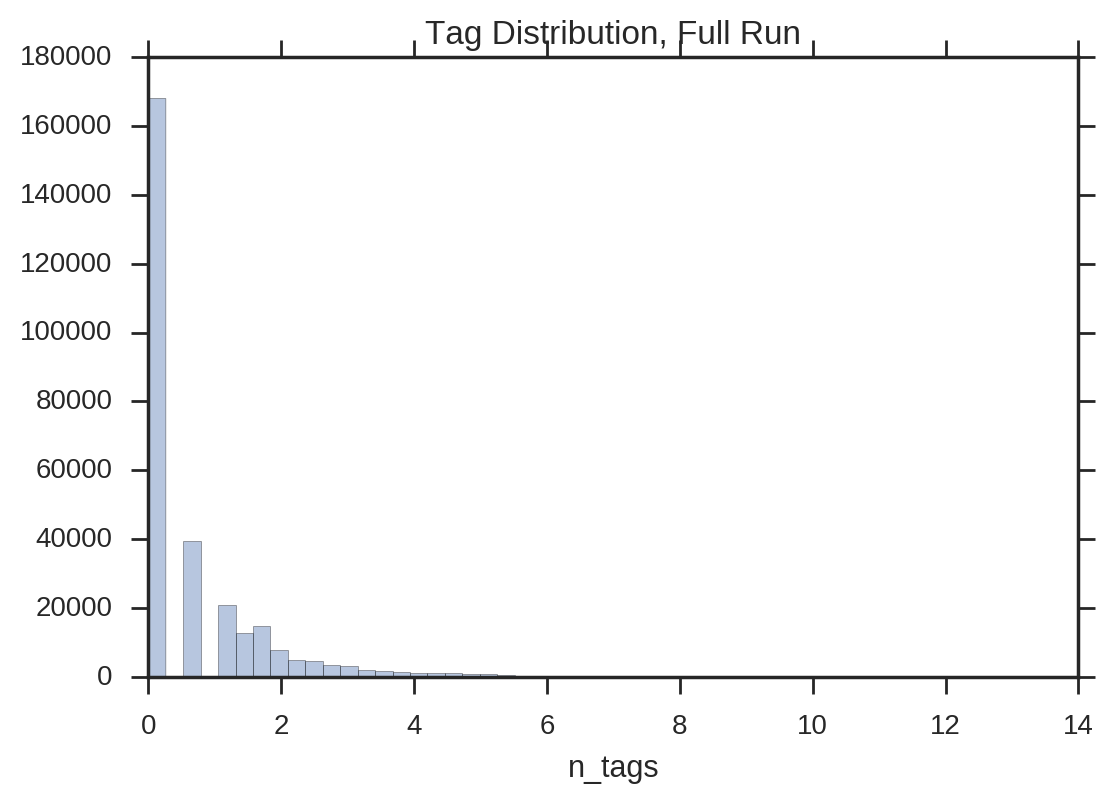

In [10]:
sns.distplot(np.log(full_data[list(full_data.keys())[-1]].n_tags), kde=False, label='log(n_tags)')
title('Tag Distribution, Full Run')

Component number quickly levels out, and eventually, reduces slightly. Total number of tags keeps increasing; this actually seems odd to me, as I'd expect tag number to level off sometime after component saturation. I also expected steady increase in component number followed by a sharp peak and decline, but instead, we got this nice smooth sort of asymptotic approach to the max number of components. 

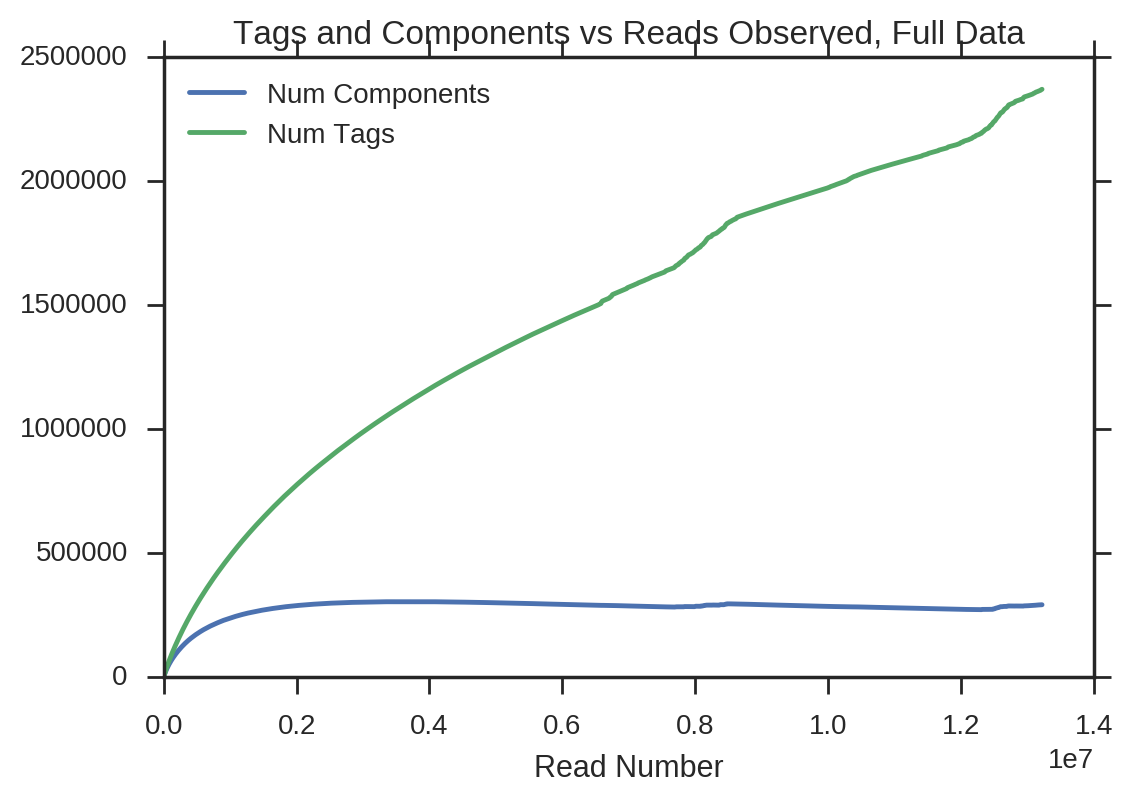

In [13]:
plot(list(full_data.keys()), [len(d) for d in full_data.values()], label='Num Components')
plot(list(full_data.keys()), [d.n_tags.sum() for d in full_data.values()], label='Num Tags')
xlabel('Read Number')
legend(loc='upper left')
title('Tags and Components vs Reads Observed, Full Data')
savefig('components_v_reads_full.png', dpi=600)

In [14]:
FileLink('components_v_reads_full.png')

/work/streaming-assembly/notebooks/components_v_reads_full.png

A quick examination of the component sizes provides some insight into this behavior -- the so called "lump" is here in full force. That expected sharp growth and decline is likely being blocked by the lump gathering up far more potential components than it should.

In [15]:
full_data[list(full_data.keys())[-1]].sort_values('n_tags', ascending=False).head()

,comp_id,n_tags,mean_cov
1,1,503519,33.569229
211,420,3969,28.012598
444,859,2428,19.813839
146,302,1887,57.498146
206,411,1817,50.170612


The size of the largest component increases steadily throughout the process.

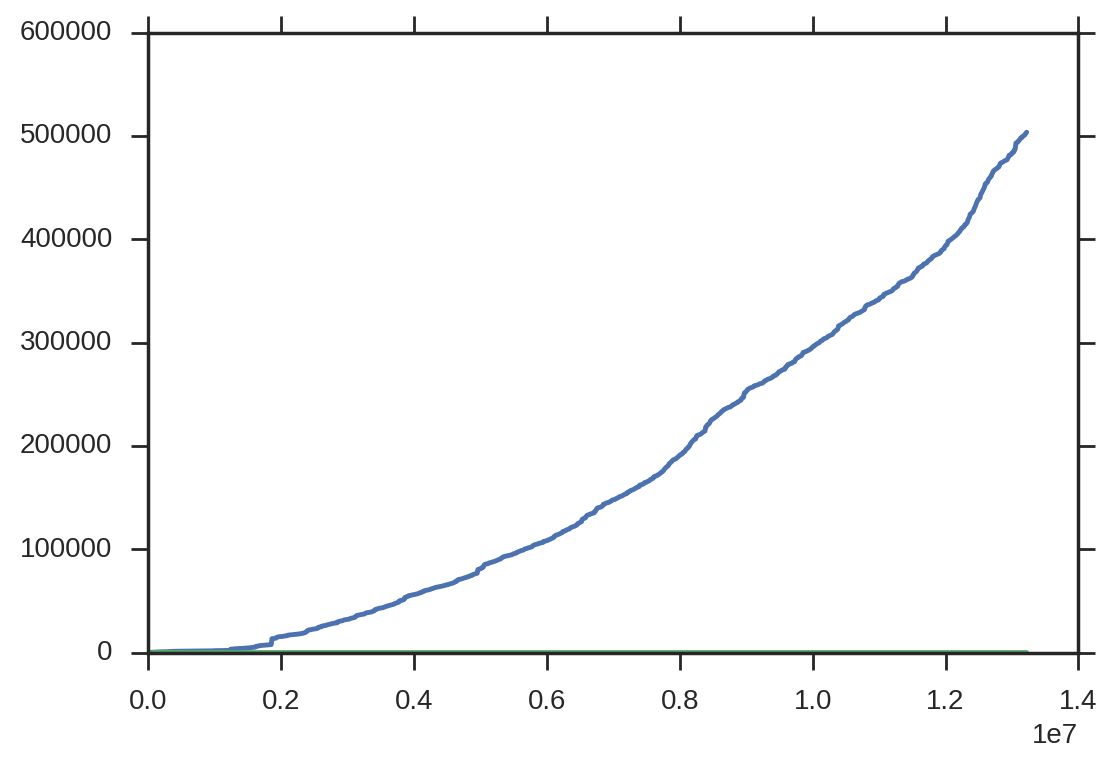

In [16]:
plot(list(full_data.keys()), [df.n_tags.max() for df in full_data.values()])
plot(list(full_data.keys()), [df.n_tags.median() for df in full_data.values()])

### Abundance-Trimmed Partitioning

In [34]:
normed_data = parse_stats_files('../../khmer/test-stats-norm')

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


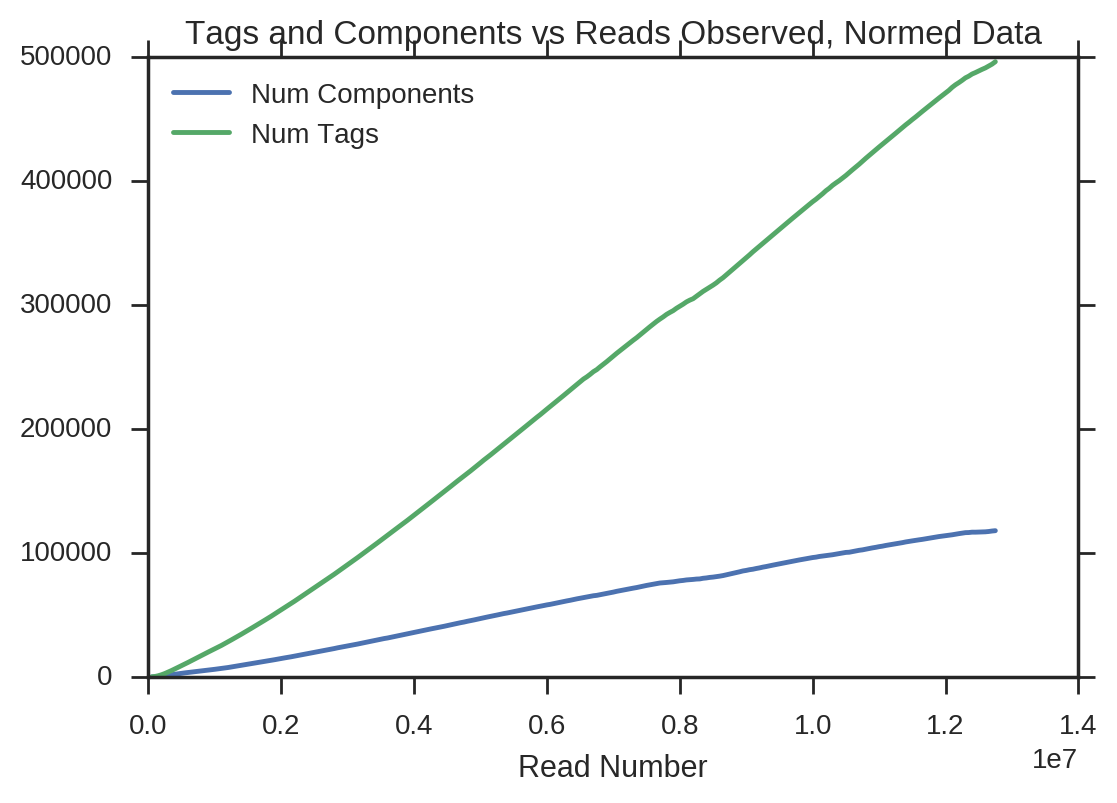

In [35]:
plot(list(normed_data.keys()), [len(d) for d in normed_data.values()], label='Num Components')
plot(list(normed_data.keys()), [d.n_tags.sum() for d in normed_data.values()], label='Num Tags')
xlabel('Read Number')
legend(loc='upper left')
title('Tags and Components vs Reads Observed, Normed Data')
savefig('components_v_reads_norm.png', dpi=600)

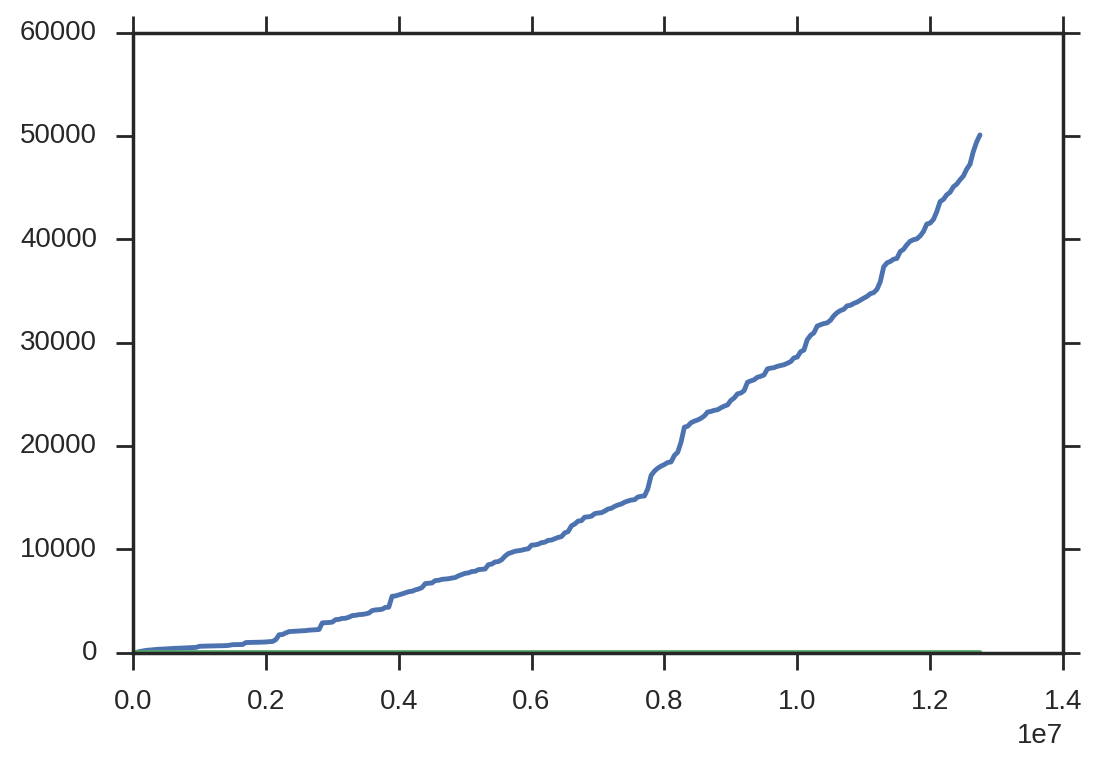

In [36]:
plot(list(normed_data.keys()), [df.n_tags.max() for df in normed_data.values()])
plot(list(normed_data.keys()), [df.n_tags.median() for df in normed_data.values()])

In [17]:
from khmer._oxli.partitioning import Component
from khmer import reverse_hash as revhash

Perhaps we can figure out something about this component by inspecting it more closely. I'll repartition the data, but this time, I'll use the faster lower-level consume functionality, and keep the partitioner around.

In [ ]:
cg = Countgraph(25, 2e9, 4)
sp = StreamingPartitioner(cg)
sp.consume_fasta('/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq')

In [56]:
comps = [(comp.component_id, comp) for comp in sp.components()]

In [57]:
lump = comps[0][1]

In [58]:
lump_counts = {tag: cg.get(revhash(tag, 25)) for tag in lump}

The $k$-mer spectrum is clearly bimodal, though the limitations of our counting structure truncate the high abundance spectrum. Regardless, there is a group of extremely high abundance $k$-mers that we can assume binds the lump together.

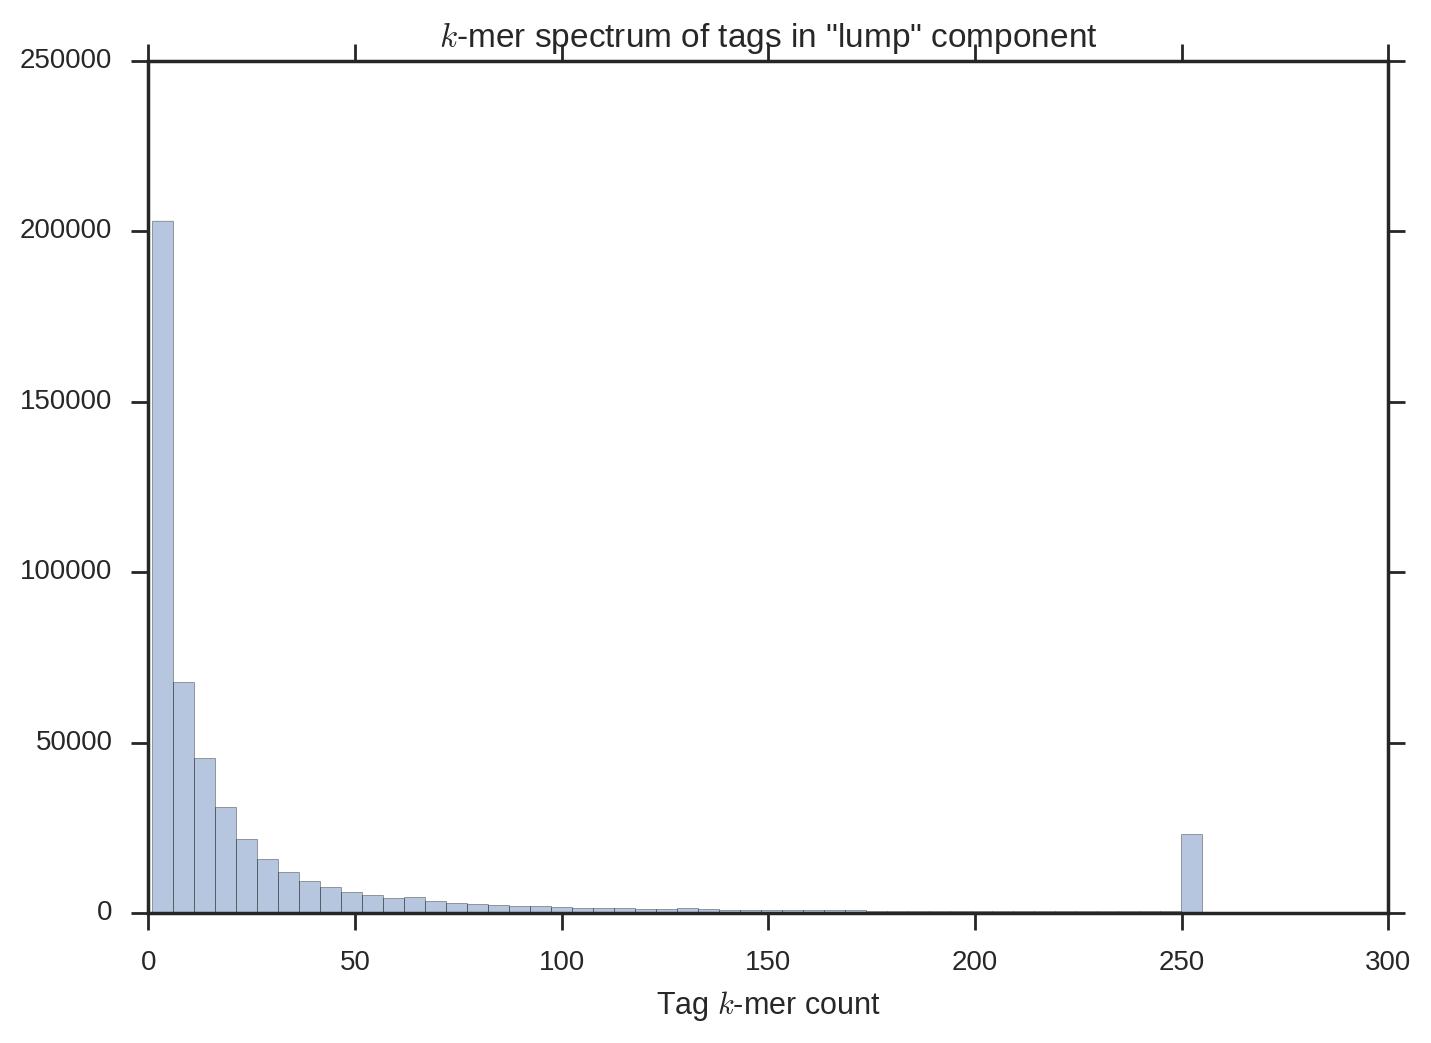

In [60]:
sns.distplot(list(lump_counts.values()), kde=False, axlabel='Tag $k$-mer count', )
title('$k$-mer spectrum of tags in "lump" component')

In [40]:
sticky_nodes = {revhash(tag, 25): count for tag, count in lump_counts.items() if count == 255}

In [68]:
with open('lump-nodes.json', 'w') as fp:
    json.dump(lump_counts, fp, indent=4)

In [16]:
asm = LinearAssembler(cg)

In [66]:
asm.assemble(sorted(list(sticky_nodes.keys()))[2])

'AAAAAAAGACAAACTTTTAACCGAG'

In [135]:
paired_data = parse_stats_files('/work/streaming-assembly/data/Asterionellopsis_glacialis_CCMP1581_SRR1300451_MMETSP1394/SRR1300451-comp-stats/')

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:06


In [136]:
single_data = parse_stats_files('/work/streaming-assembly/data/Asterionellopsis_glacialis_CCMP1581_SRR1300451_MMETSP1394/SRR1300451-single-comp-stats/')

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:28


In [139]:
from ficus import FigureManager

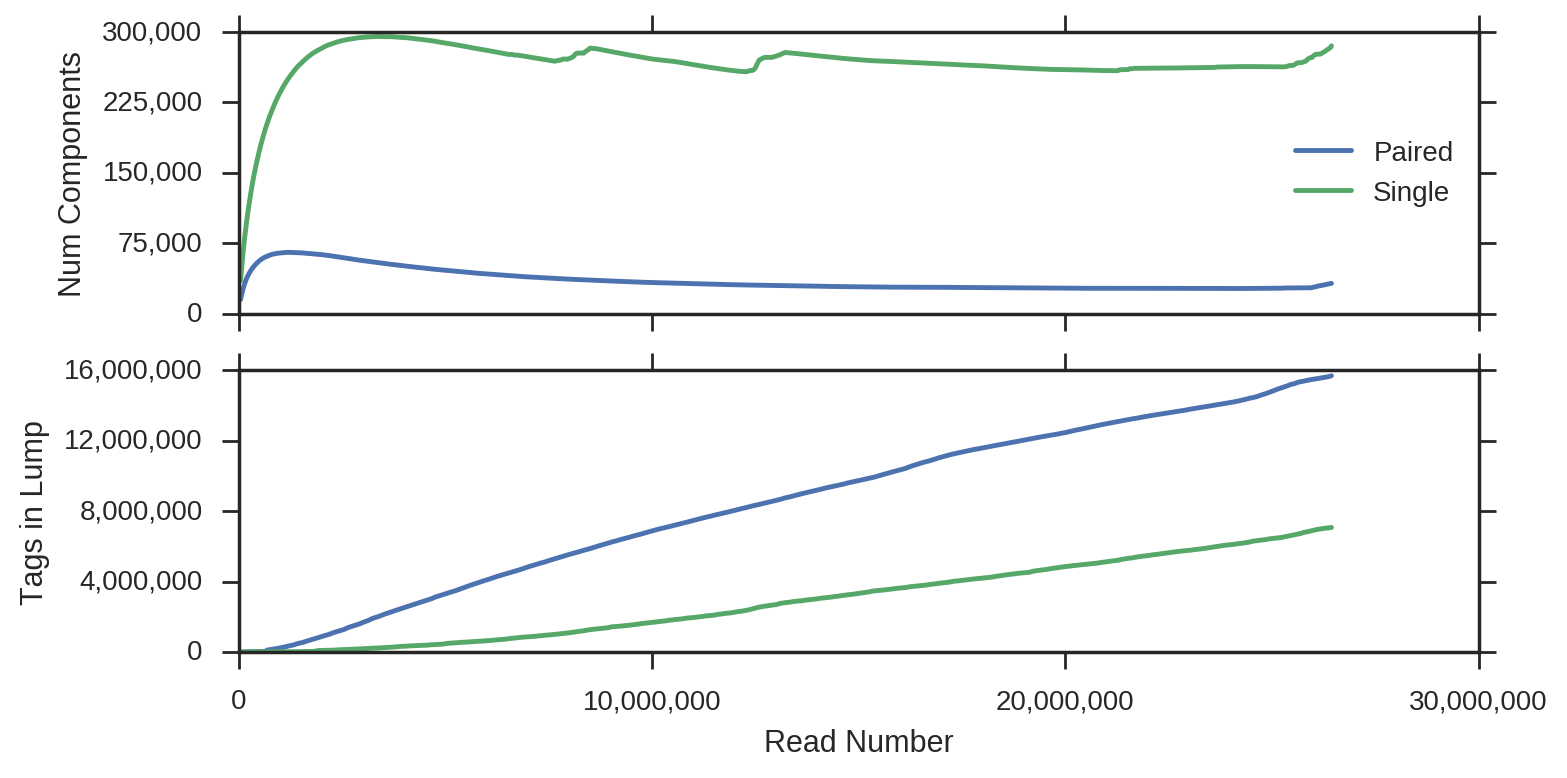

In [182]:
with FigureManager(show=True, nrows=2, sharex=True, figsize=(8,4)) as (fig, ax):
        
    ax[0].plot(list(paired_data.keys()), [len(d) for d in paired_data.values()], label='Paired')
    ax[0].plot(list(single_data.keys()), [len(d) for d in single_data.values()], label='Single')
    ax[0].set_ylabel('Num Components')
    
    ax[1].plot(list(paired_data.keys()), [df.n_tags.max() for df in paired_data.values()], label='Paired')
    ax[1].plot(list(single_data.keys()), [df.n_tags.max() for df in single_data.values()], label='Single')

    ax[1].set_xlabel('Read Number')
    ax[1].set_ylabel('Tags in Lump')

    for _ in ax:
        _.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        _.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        start, end = _.get_ylim()
        _.yaxis.set_ticks(np.arange(start, end+1, end/4))

    # Modify x-axis ticks
    start, end = ax[1].get_xlim()
    ax[1].xaxis.set_ticks(np.arange(start, end+1, end/3))

    ax[0].legend(loc='center right')
    #ax[1].legend(loc='center right')
    #ax[0].set_title('Component growth during assemly graph construction, SRR1300451')
    fig.savefig('/work/recomb-poster/output/img/lump_domination.png', dpi=300)

In [157]:
for _ in ax:
    print(_)

Axes(0.125,0.547727;0.775x0.352273)
Axes(0.125,0.125;0.775x0.352273)


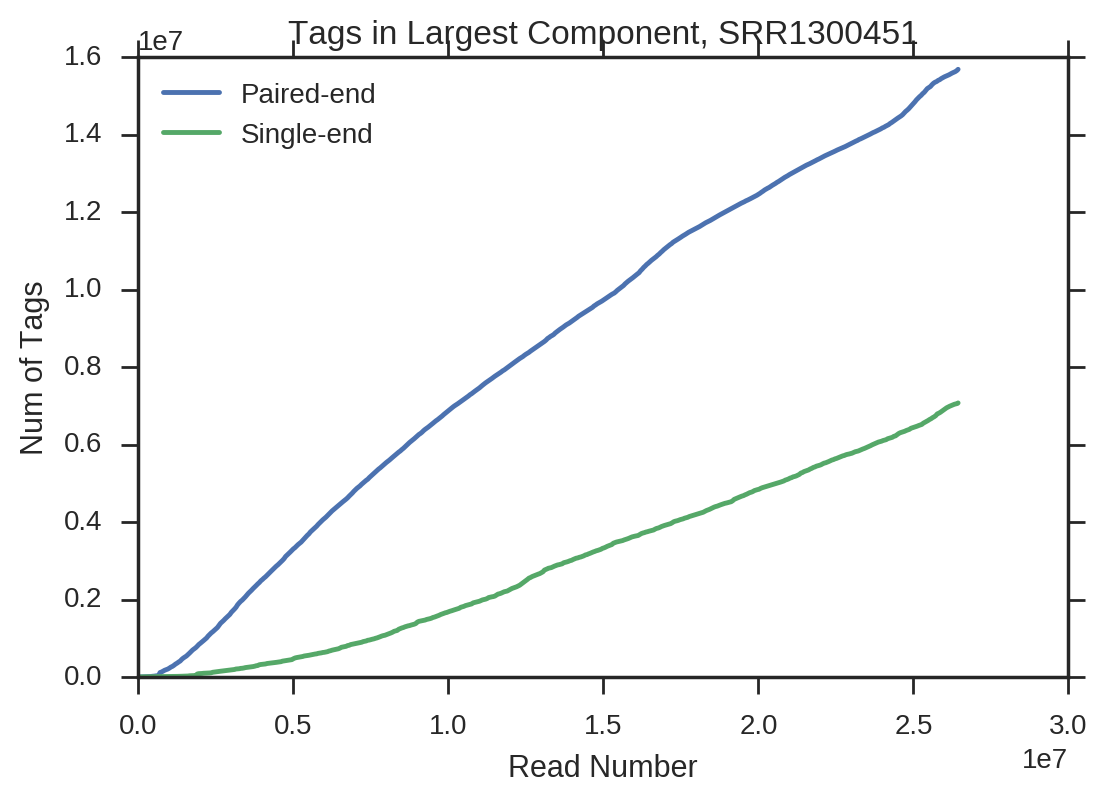

In [70]:
plot(list(paired_data.keys()), [df.n_tags.max() for df in paired_data.values()], label='Paired-end')
plot(list(single_data.keys()), [df.n_tags.max() for df in single_data.values()], label='Single-end')

xlabel('Read Number')
ylabel('Num of Tags')
legend(loc='upper left')
title('Tags in Largest Component, SRR1300451')
savefig('largest_component_size_paired_and_single.png', dpi=600)

In [19]:
cg = Countgraph(25, 2e9, 4)
cg.consume_fasta('/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq')
cg.consume_fasta('/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_2.fastq')

(13221196, 343278910)

In [7]:
partapp = PartitioningApp(['--ksize', '25', '-x', '2e9', '--stats-dir', 'SRR1300451-comp-stats-2',
                           '--stats-interval', '50000', '--pairing-mode', 'split',
                          '/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq',
                          '/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_2.fastq'])

In [ ]:
%time P_paired = partapp.run()

== Starting (/store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_1.fastq./store/biodb/MMETSP/data/Asterionellopsis_glacialis/SRR1300451/SRR1300451_2.fastq) ==
0...
1000...
2000...
3000...
4000...
5000...
6000...
7000...
8000...
9000...
10000...
11000...
12000...
13000...
14000...
15000...
16000...
17000...
18000...
19000...
20000...
21000...
22000...
23000...
24000...
25000...
26000...
27000...
28000...
29000...
30000...
31000...
32000...
33000...
34000...
35000...
36000...
37000...
38000...
39000...
40000...
41000...
42000...
43000...
44000...
45000...
46000...
47000...
48000...
49000...
50000...
# 50000: 533230 tags, 41146 components.
  writing results to file -> SRR1300451-comp-stats-2/50000.SRR1300451_2.fastq.stats.csv
51000...
52000...
53000...
54000...
55000...
56000...
57000...
58000...
59000...
60000...
61000...
62000...
63000...
64000...
65000...
66000...
67000...
68000...
69000...
70000...
71000...
72000...
73000...
74000...
75000...
76000...
77000...
78

In [11]:
comps = [(comp.component_id, comp) for comp in P_paired.components()]

In [12]:
lump = comps[0][1]

In [15]:
len(lump)

15681997

## Conditional Partitioning

In [248]:
condp_df = pd.read_csv('../SRR1300451-K31-sliced-c5c10/partitioner-details.csv', 
                       skipinitialspace=True, na_values='None')

In [249]:
condp_df.head()

,read_n,fitness,n_tags,n_merged,comp_size,comp_cov,root_id
0,2,0.0,2,NaN,NaN,NaN,NaN
1,4,0.0,2,NaN,NaN,NaN,NaN
2,6,0.0,2,NaN,NaN,NaN,NaN
3,8,0.0,2,NaN,NaN,NaN,NaN
4,10,0.0,2,NaN,NaN,NaN,NaN


In [250]:
condp_sub = condp_df.sample(n=100000, axis=0).sort_values('read_n')

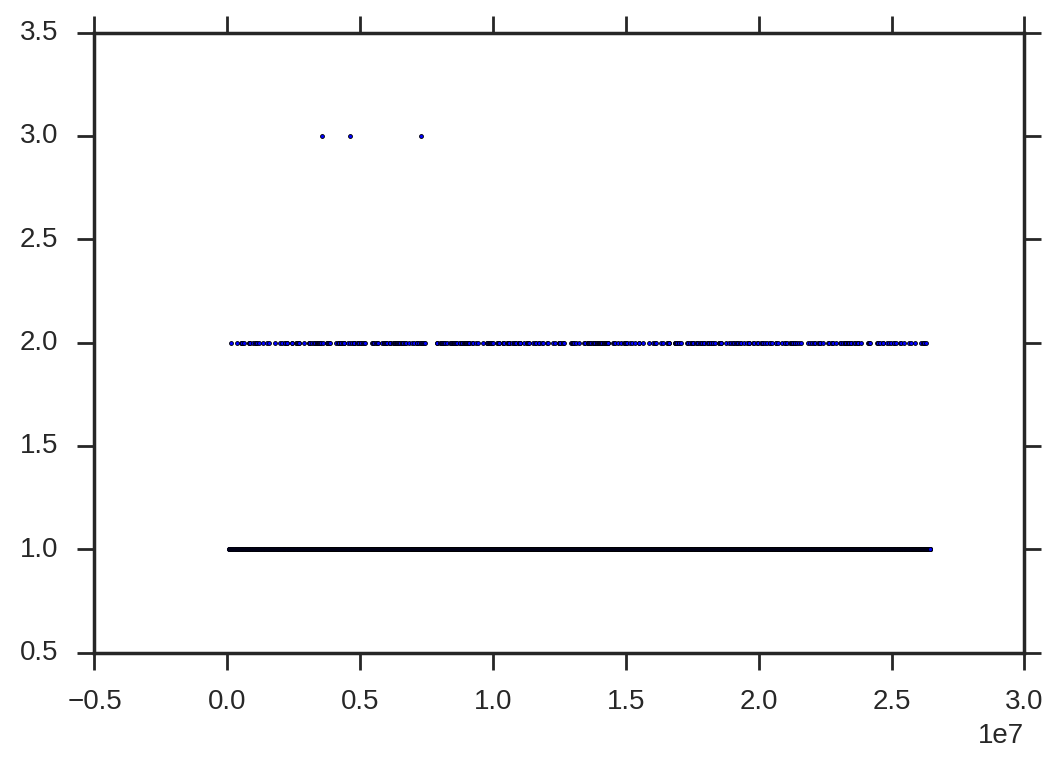

In [251]:
#scatter(condp_sub['read_n'], condp_sub['comp_size'], s=2)
scatter(condp_sub['read_n'], condp_sub['n_merged'], s=2)

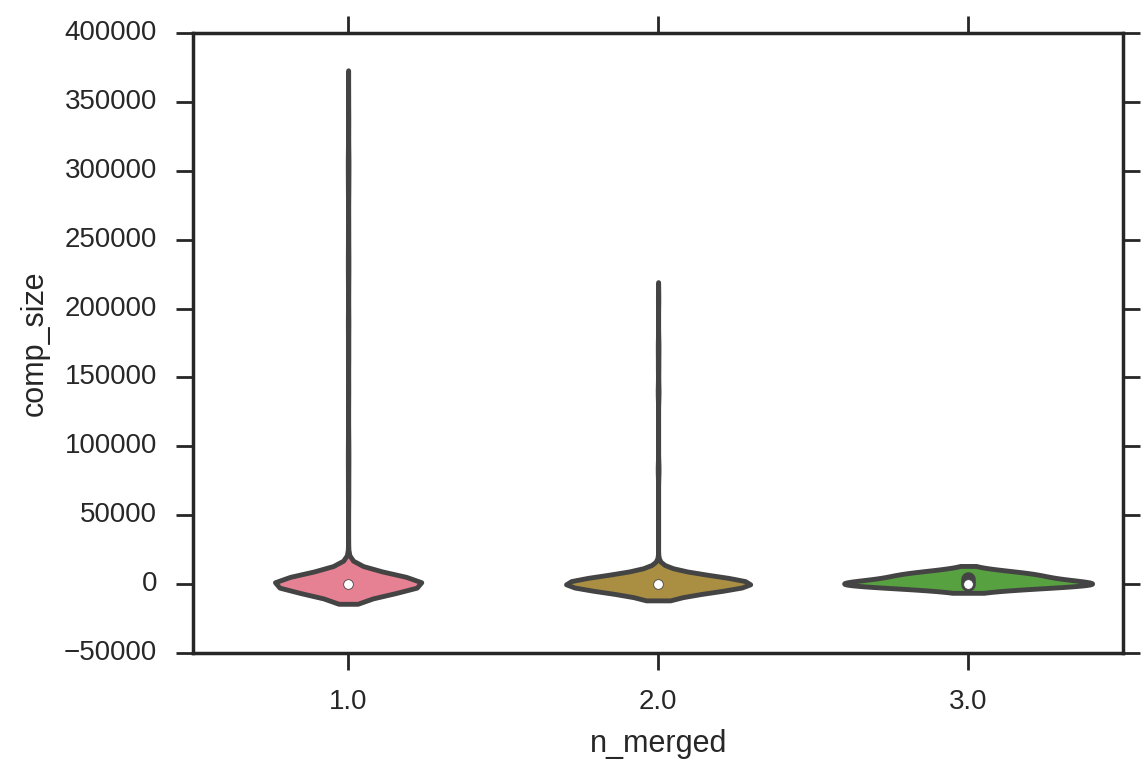

In [252]:
sns.violinplot(x="n_merged", y="comp_size", data=condp_sub, jitter=True)

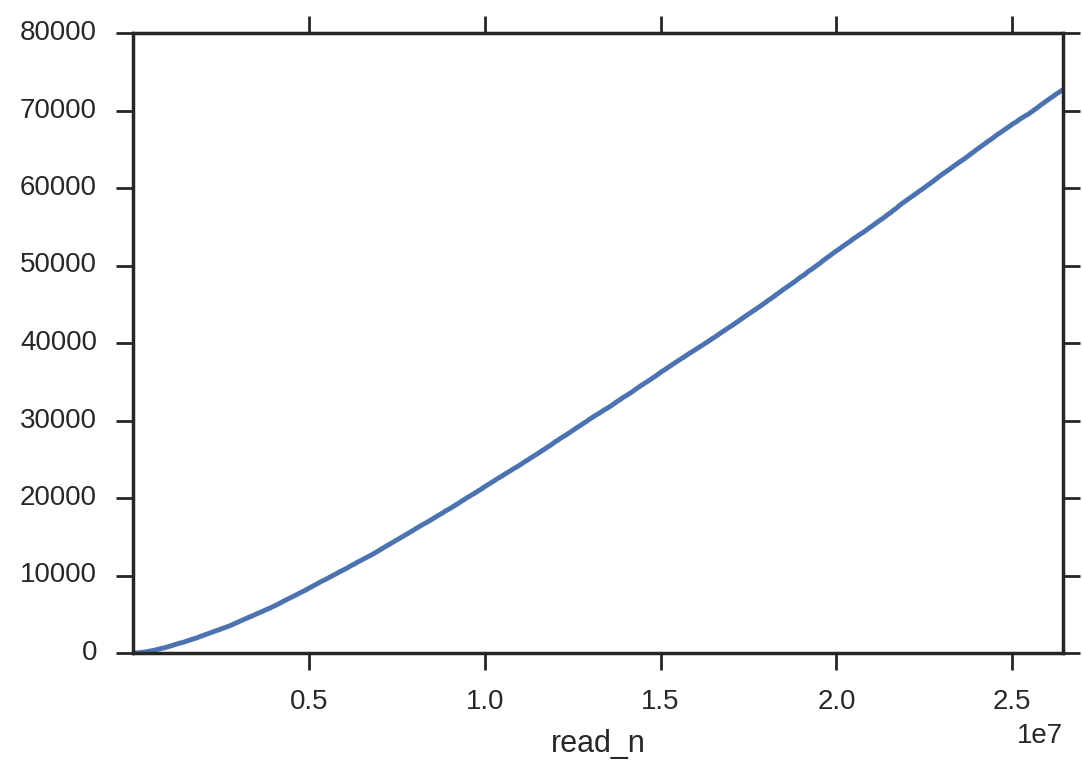

In [55]:
condp_sub.set_index('read_n').n_merged.replace(to_replace=NaN, value=0).cumsum(skipna=True).plot()

In [76]:
condp_comps = pd.read_csv('../SRR1300451-K31-detailed/global.csv',
                          names=['read_n', 'n_components', 'n_tags', 'new_kmers'])

In [80]:
condp_sliced_comps = pd.read_csv('../SRR1300451-K31-sliced-c5c10/global.csv',
                          names=['read_n', 'n_components', 'n_tags', 'new_kmers'])

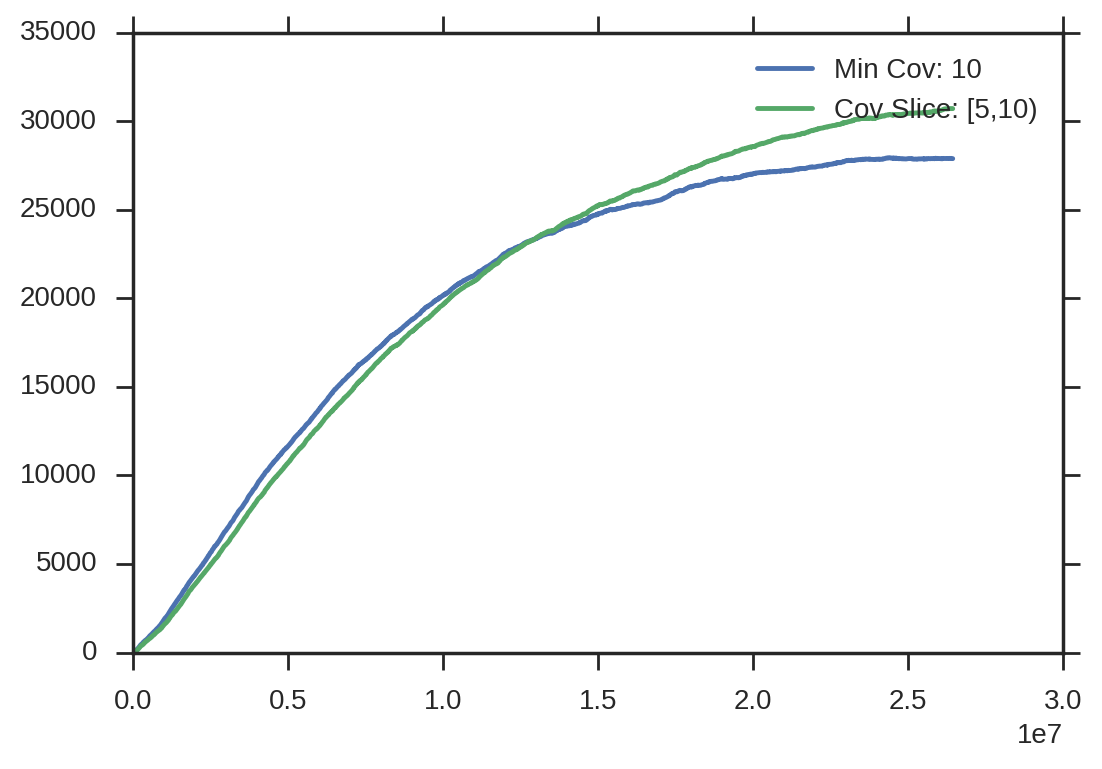

In [83]:
plot(condp_comps.read_n, condp_comps.n_components, label='Min Cov: 10')
plot(condp_sliced_comps.read_n, condp_sliced_comps.n_components, label='Cov Slice: [5,10)')
legend()

In [84]:
condp_sliced = pd.read_csv('../SRR1300451-K31-sliced-c5c10/partitioner-details.csv', 
                       skipinitialspace=True, na_values='None')

In [94]:
def parse_partition_data_dir(stats_dir, include_global=False, verbose=True):
    stats_files = [os.path.abspath(p) for p in glob.glob(os.path.join(stats_dir,'*.csv')) if not \
                   (p.endswith('global.csv') or p.endswith('partitioner-details.csv'))]
    read_num_func = lambda fn: int(os.path.basename(fn).split('.')[0])
    stats_files.sort(key=read_num_func)
    if verbose:
        print('Parsing {0} partition files from {1}'.format(len(stats_files), stats_dir))
        bar = pyprind.ProgBar(len(stats_files), monitor=False)
    
    data = OrderedDict()
    for filename in stats_files:
        df = pd.read_csv(filename, header=None, names=['comp_id', 'n_tags', 'mean_cov'])
        data[read_num_func(filename)] = df
        if verbose:
            bar.update()
    return data

In [95]:
condp_all = parse_partition_data_dir('../SRR1300451-K31-sliced-c5c10/')

0%                          100%
[#                             ] | ETA: 00:00:02

Parsing 2645 partition files from ../SRR1300451-K31-sliced-c5c10/


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:15


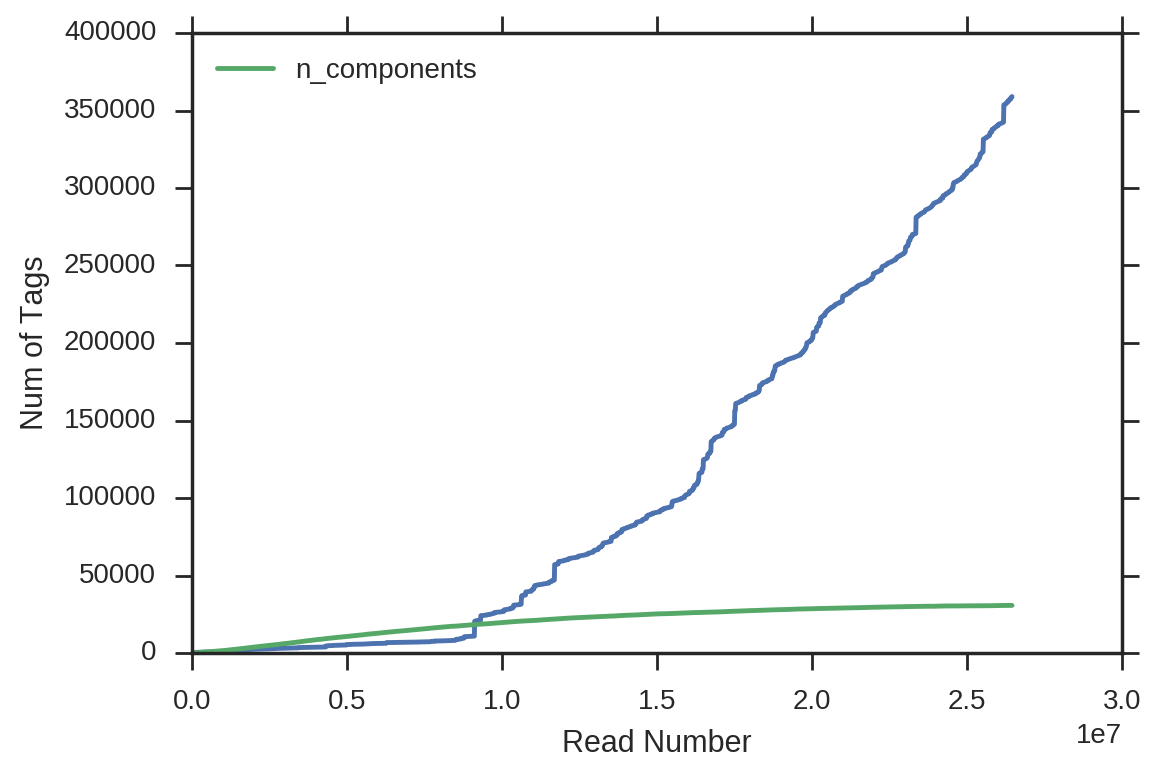

In [98]:
plot(list(condp_all.keys()), [df.n_tags.max() for df in condp_all.values()])
plot(condp_sliced_comps.read_n, condp_sliced_comps.n_components)

xlabel('Read Number')
ylabel('Num of Tags')
legend(loc='upper left')
#title('Tags in Largest Component, SRR1300451')
#savefig('largest_component_size_paired_and_single.png', dpi=600)

In [122]:
dcov_dt = pd.concat([df.quantile(q=np.arange(.1,1,.1))[['mean_cov']].rename(columns={'mean_cov': N}).T \
                     for N, df in condp_all.items() if not df.empty])

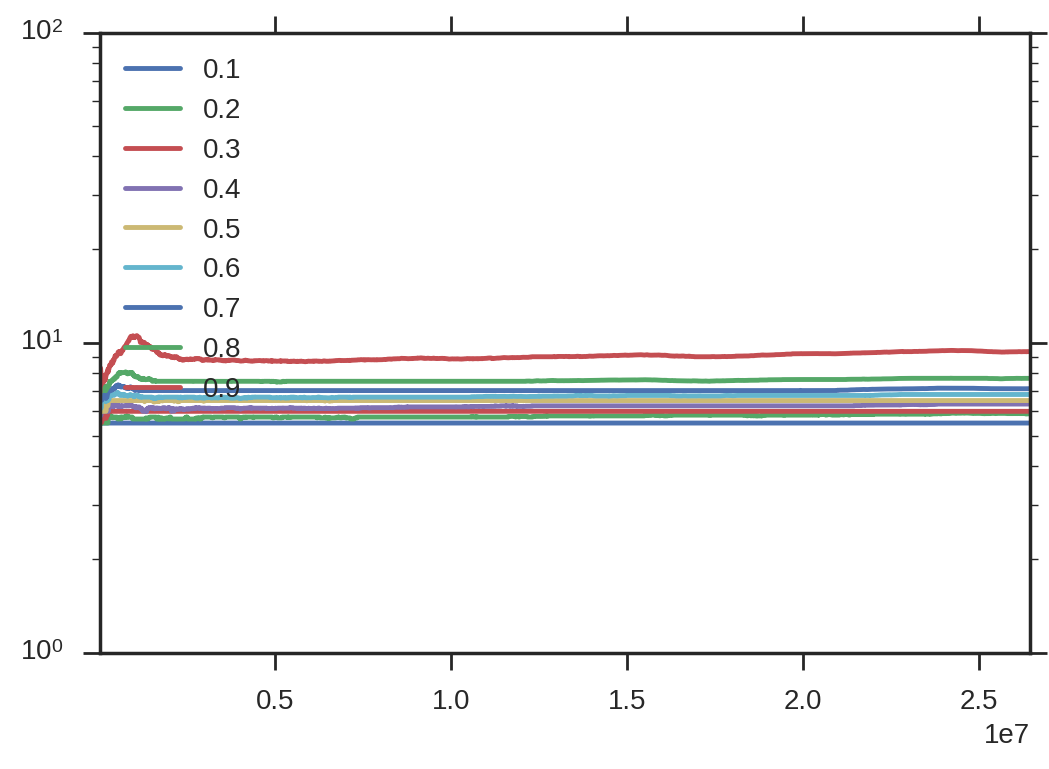

In [128]:
dcov_dt.plot(logy=True)

In [193]:
quantiles = pd.concat([df.quantile(q=[.1, .25, .5, .75, .9])[['mean_cov', 'n_tags']].T \
                       for N, df in condp_all.items() if not df.empty])
quantiles.reset_index(inplace=True)
quantiles.rename(columns={'index': 'measure'}, inplace=True)
quantiles['read_n'] = np.repeat([N for N, df in condp_all.items() if not df.empty], 2)

In [197]:
quantiles.set_index('read_n', inplace=True)

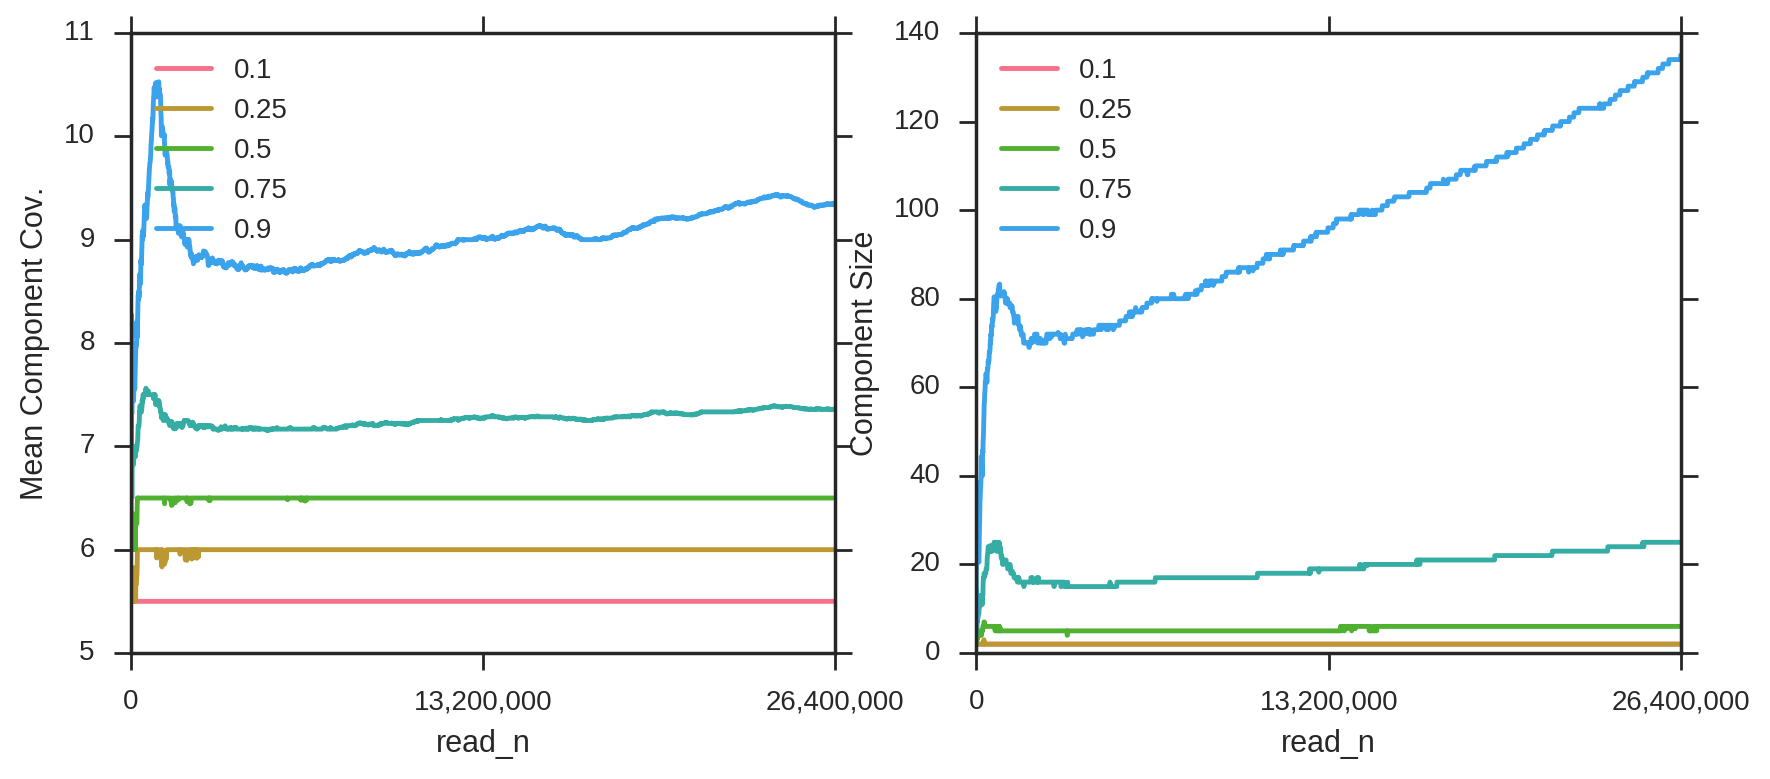

In [245]:
with FigureManager(show=True, ncols=2, figsize=(10,4)) as (fig, ax):
    
    #cmap = sns.color_palette("cubehelix", 8, )
    #sns.set_palette("GnBu_d", )
    sns.set_palette("husl")
    quantiles.query('measure == "mean_cov"').plot(ax=ax[0])
    ax[0].set_ylabel('Mean Component Cov.')
    quantiles.query('measure == "n_tags"').plot(ax=ax[1]) #, colormap=cmap)
    ax[1].set_ylabel('Component Size')

    for _ in ax:
        _.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(round(int(x), -5), ',')))
        start, end = _.get_xlim()
        _.xaxis.set_ticks(list(np.arange(start, end+1, end/2)) + [end])
        
        start, end = _.get_ylim()
        #_.yaxis.set_ticks(list(np.arange(start, end, end/3)) + [end])
        #_.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    #ax[0].set_title('Component growth during assemly graph construction, SRR1300451')
    fig.savefig('/work/recomb-poster/output/img/component_quantiles.png', dpi=300)

In [209]:
format(round(int(54334455), -5), ',')

'54,300,000'

In [ ]:
df.plot()